In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor
from torchmetrics.classification import MulticlassAccuracy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

### Getting a Dataset

- download the data
- and turn it into dataloader

In [3]:
train_data = datasets.FashionMNIST(root = 'data', train=True, download=True, transform=ToTensor(), target_transform= None)

test_data = datasets.FashionMNIST(root = 'data', train=False, download=True, transform=ToTensor(), target_transform= None)


### Understanding Data

In [4]:
# len(train_data), len(test_data)


image, label = train_data[0]

# image, label


# train_data.classes


# class_to_idx = train_data.class_to_idx

# class_to_idx


# image.shape, label


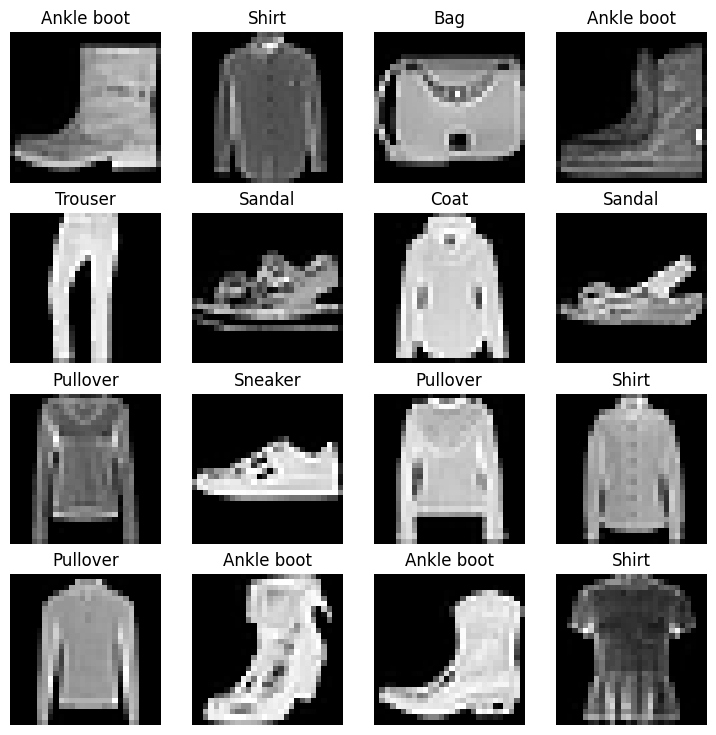

In [5]:
# plot more images

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

### Turning Data from Dataset into DataLoader

Right now our data is in the form of pytorch datasets. 

Dataloader turns dataset into a Python Iterable. More specifically, we want to turn our data into mini  batches.

In [6]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

device

'cuda'

In [10]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)

In [11]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x238f9914be0>,
 <torch.utils.data.dataloader.DataLoader at 0x238d885a760>)

In [12]:
print(f"No of batches in train data loader {len(train_dataloader)}")
print(f"No of batches in test data loader {len(test_dataloader)}")

No of batches in train data loader 1875
No of batches in test data loader 313


In [13]:
# show a ranodm sample from dataloader

train_batch, batch_labels = next(iter(train_dataloader))

train_batch.shape, batch_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [14]:
img, label = train_batch[1], batch_labels[1]

image size torch.Size([1, 28, 28])
label 1


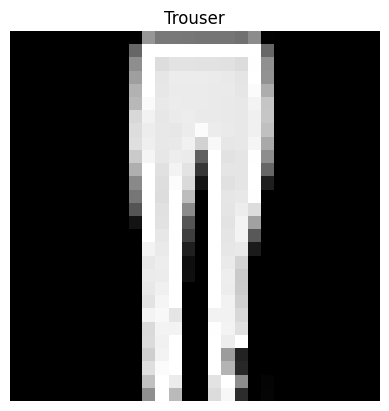

In [15]:
plt.imshow(img.squeeze(), cmap="gray");
plt.title(train_data.classes[label]);
plt.axis(False);

print(f"image size {img.shape}")
print(f"label {label}")

### Model Building

#### 0) Baseline Model

In [17]:
class FashionMNISTV0(nn.Module):
    def __init__(self, input_shape:int,
                  hidden_units:int,
                    output_shape:int):
        super().__init__()
        
        # block 1 - two conv layers with kernel size 3
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size=3, stride = 1, padding = 1),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = hidden_units,
                                out_channels = hidden_units, 
                                kernel_size=3,
                                stride=1,
                                padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2)
        )

        # block 2 - two conv layers with kernel size 3
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
                    nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        #  output block - Flatten layers, Fully connected layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, 
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [18]:
torch.manual_seed(42)
model_0 = FashionMNISTV0(input_shape= 1, hidden_units=10, output_shape=len(train_data.classes)).to(device)
model_0

FashionMNISTV0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [19]:
# timing function
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device:torch.device=None):
    total_time = end - start
    print(f"train time on {device} is {total_time:.3f} seconds")
    return total_time

In [26]:
# writing training function
def train_step(model,
                data_loader, 
                loss_fn, 
                optimizer, 
                acc_fn, device=device):
    
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")



# wrting test loop function

def test_step(model, data_loader,loss_fn, acc_fn, device = device):
    test_loss, test_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += acc_fn(test_pred.argmax(dim=1), y_test)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")


# evalution loop

torch.manual_seed(42)

def eval_model(model, data_loader, loss_fn, acc_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y, y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"loss ": loss.item(), "model acc: ": acc}

In [27]:

torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
metric = MulticlassAccuracy(num_classes=10).to(device)


train_time_start_gpu = timer()


EPOCHS = 10
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch : {epoch} \n------------")

    # train pass
    train_step(model=model_0, 
               data_loader=train_dataloader, 
               loss_fn=loss_fn, 
               optimizer=optimizer,
               acc_fn=metric, 
               device=device)
    # testing pass
    test_step(model=model_0, 
              data_loader=test_dataloader, 
              loss_fn=loss_fn, 
              acc_fn=metric, 
              device=device)



train_time_end_gpu = timer()
total_train_time = print_train_time(train_time_start_gpu, train_time_end_gpu, device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0 
------------
Train loss: 0.59482 | Train acc: 0.75%
Test loss: 0.39288 | Test acc: 0.83%

Epoch : 1 
------------
Train loss: 0.36034 | Train acc: 0.84%
Test loss: 0.35391 | Test acc: 0.84%

Epoch : 2 
------------
Train loss: 0.32039 | Train acc: 0.85%
Test loss: 0.33049 | Test acc: 0.85%

Epoch : 3 
------------
Train loss: 0.29496 | Train acc: 0.86%
Test loss: 0.32364 | Test acc: 0.85%

Epoch : 4 
------------
Train loss: 0.27926 | Train acc: 0.87%
Test loss: 0.30110 | Test acc: 0.86%

Epoch : 5 
------------
Train loss: 0.26645 | Train acc: 0.88%
Test loss: 0.30718 | Test acc: 0.86%

Epoch : 6 
------------
Train loss: 0.25967 | Train acc: 0.87%
Test loss: 0.29255 | Test acc: 0.87%

Epoch : 7 
------------
Train loss: 0.25351 | Train acc: 0.88%
Test loss: 0.29016 | Test acc: 0.87%

Epoch : 8 
------------
Train loss: 0.24684 | Train acc: 0.88%
Test loss: 0.29010 | Test acc: 0.87%

Epoch : 9 
------------
Train loss: 0.24280 | Train acc: 0.88%
Test loss: 0.31462 | Test ac

In [28]:
model_0_result = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, acc_fn=metric)

  0%|          | 0/313 [00:00<?, ?it/s]

In [29]:
print(model_0_result)

{'loss ': 0.31462353467941284, 'model acc: ': tensor(0.8600, device='cuda:0')}


#### Predictions

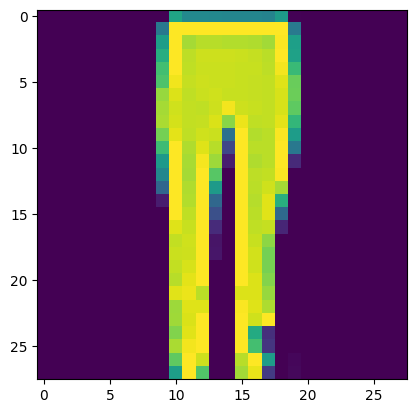

In [30]:
img, label = train_batch[1], batch_labels[1]

plt.imshow(img.squeeze())

In [31]:
model_0.eval()
with torch.inference_mode():
    img, label = img.to(device), label.to(device)
    pred = model_0(img.unsqueeze(0))

In [32]:
pred

tensor([[ 0.3795, 17.9743, -4.7170, -1.0068,  0.1138,  0.1964, -2.0784, -2.9247,
         -3.0023, -4.8663]], device='cuda:0')

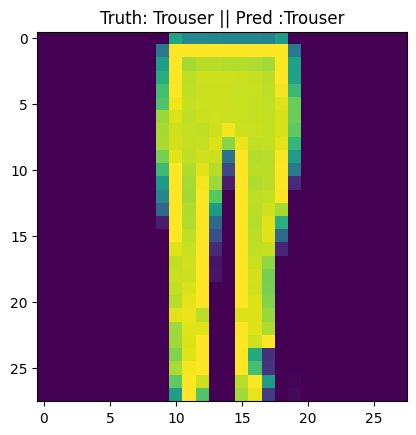

In [34]:
plt.imshow(img.squeeze().cpu())
plt.title(f"Truth: {train_data.classes[label]} || Pred :{train_data.classes[pred.argmax()]}");

#### Cofustion Matrix

In [35]:
y_preds = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Predictions ......"):
        X, y = X.to(device), y.to(device)
        y_logits = model_0(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

print(y_preds)


Making Predictions ......:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 6, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 6, 4, 6, 3, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 1, 3, 3, 7, 8, 7, 0, 2, 3, 2, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 0]), tensor([0, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 3, 2, 2, 3, 4,
        1, 3, 5, 6, 4, 7, 9, 3]), tensor([7, 2, 3, 8, 0, 9, 4, 7, 4, 8, 6, 5, 6, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6,
        7, 9, 8, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 3, 7, 0, 7, 8, 9, 2, 9, 3, 5, 1, 3, 4, 5, 4, 3, 2, 2, 8, 6, 4,
        3, 2, 7, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4,
       

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [37]:
cm = confusion_matrix(torch.cat(y_preds), test_dataloader.dataset.targets)

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=train_data.classes)

<Figure size 2000x2000 with 0 Axes>

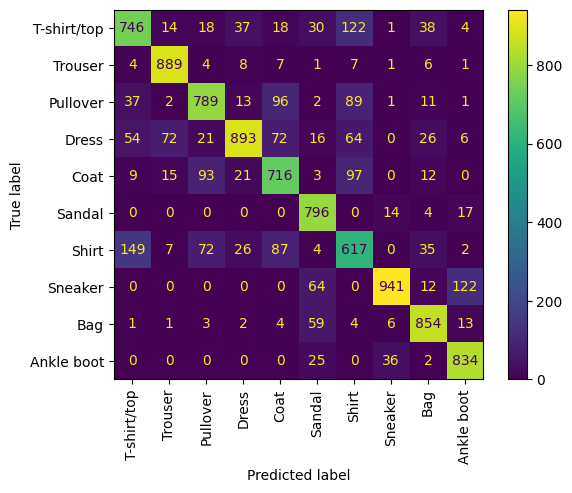

In [39]:
plt.figure(figsize=(20, 20))
disp.plot(xticks_rotation='90')
plt.show()
